# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Исследую сеть отелей"Как в гостях". Для увеличения трафика, сеть внедрила опцию по бронированию номеров без предоплаты. В случае отмены брони отель терпел убытки, так как подготовка номера включает в себя уборку и заказ продуктов. Для решения этой проблемы, необходимо создать систему, которая бы предсказывала отказ от бронирования. Результатом хорошей модели будет ситуация, при которой человеку, который попадает в модель как отказник, будет предложено внести депозит. Размер депозита обусловлен расходами на подготовку опций и уборку = 80%.Деньги будут списаны со счета если произойдет отмена.

Для реализации проекта проведем исследование данных и поиск закономерностей, которые ведут к отмене, проработаем бизнес - метрики, которые станут основой исследования и обучим модели. Они дадут возможность определить необходимость депозита. Исходя из результатов исследования составим портрет "Надежного клиента".

Наш целевой признак is_canceled, его будем исследовать.

### Шаг 1. Откроем файлы с данными

In [1]:
 %pip install category_encoders 

     |████████████████████████████████| 81 kB 1.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import scipy
from scipy import stats as st
from sklearn import metrics
import random


from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors as mcolors
from matplotlib.collections import PolyCollection

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.model_selection import cross_val_score
import joblib
RANDOM_STATE = 42

In [3]:
import warnings
warnings.filterwarnings("ignore") # Скроем ошибки и предупреждения

In [4]:
pd.set_option('display.max_columns', None) # Отобразим все столбцы

In [5]:
hotel_train = pd.read_csv("https://code.s3.yandex.net/datasets/hotel_train.csv") #Открываем
hotel_test = pd.read_csv("https://code.s3.yandex.net/datasets/hotel_test.csv")

Посмотрим информацию по датасету hotel_train

In [6]:
display(hotel_train.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


Ознакомимся с общей информацией о датасете

In [7]:
print(hotel_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [8]:
print('Количество дубликатов:', hotel_train['id'].duplicated().sum())

Количество дубликатов: 0


Выясним количество пропусков

In [9]:
print(f'''Пропусков:
{hotel_train.isna().sum()}''')

Пропусков:
id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


In [10]:
 display(hotel_train.describe())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


In [11]:
print(hotel_train.shape)

(65229, 25)


Ознакомимся с данными по тестовому датасету

In [12]:
display(hotel_test.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


In [13]:
print(hotel_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [14]:
print(f'''Пропусков:
{hotel_test.isna().sum()}''')

Пропусков:
id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


In [15]:
print('Количество дубликатов:', hotel_test['id'].duplicated().sum())

Количество дубликатов: 0


In [16]:
display(hotel_test.describe())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


In [17]:
print(hotel_test.shape)

(32412, 25)


In [18]:
hotel_train.dtypes == hotel_test.dtypes #Смотрим, одинаковы ли типы данных в датасетах

id                                True
is_canceled                       True
lead_time                         True
arrival_date_year                 True
arrival_date_month                True
arrival_date_week_number          True
arrival_date_day_of_month         True
stays_in_weekend_nights           True
stays_in_week_nights              True
adults                            True
children                          True
babies                            True
meal                              True
country                           True
distribution_channel              True
is_repeated_guest                 True
previous_cancellations            True
previous_bookings_not_canceled    True
reserved_room_type                True
booking_changes                   True
days_in_waiting_list              True
customer_type                     True
required_car_parking_spaces       True
total_of_special_requests         True
total_nights                      True
dtype: bool

In [19]:
#Проверим нулевые значения в столбце со взрослыми постояльцами, т.к это главный индикатор корректного содержимого
zero_train = hotel_train.loc[(hotel_train['adults'] == 0) & (hotel_train['children'] == 0), 'adults']
print('Ноль постояльцев в hotel_train:', zero_train.count())

Ноль постояльцев в hotel_train: 15


In [20]:
zero_test = hotel_test.loc[(hotel_test['adults'] == 0) & (hotel_test['children'] == 0), 'adults']
print('Ноль постояльцев в hotel_test:', zero_test.count())

Ноль постояльцев в hotel_test: 7


In [21]:
categ_col = hotel_train.loc[:,  (hotel_train.dtypes == 'object')].columns #Список категориальных столбцов object

Проверим категориальные столбцы в обоих датасетах на скрытые дубликаты

In [22]:
sets = [hotel_train, hotel_test]
for item in sets:    
    for column in categ_col:
        print(f'Количество уникальных значений {column}:', item[column].nunique())
        print(sorted(item[column].unique()))

Количество уникальных значений arrival_date_month: 12
['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September']
Количество уникальных значений meal: 5
['BB       ', 'FB       ', 'HB       ', 'SC', 'SC       ']
Количество уникальных значений country: 155
['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATA', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA', 'BRB', 'BWA', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GGY', 'GIB', 'GLP', 'GNB', 'GRC', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KHM', 'KNA', 'KOR', 'KWT', 'LBN', 'LBY', 'LCA', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'M

### Шаг 2. Предобработка и исследовательский анализ данных

In [23]:
#Удаляем строки с нулевым количеством постояльцев
hotel_train = hotel_train.drop(zero_train.index).reset_index(drop=True)
hotel_test = hotel_test.drop(zero_test.index).reset_index(drop=True)

In [24]:
hotel_train.shape

(65214, 25)

In [25]:
hotel_test.shape

(32405, 25)

In [26]:
datas = [hotel_train, hotel_test]
for data in datas: #Исправляем ошибочные значения, заменяя их базовыми
    for column in ['meal', 'reserved_room_type']:
        data[column] = data[column].str.strip()
        print(sorted(data[column].unique()))
        print(f'Количество уникальных значений {column}:', data[column].nunique())

['BB', 'FB', 'HB', 'SC']
Количество уникальных значений meal: 4
['A', 'B', 'C', 'D', 'E', 'F', 'G']
Количество уникальных значений reserved_room_type: 7
['BB', 'FB', 'HB', 'SC']
Количество уникальных значений meal: 4
['A', 'B', 'C', 'D', 'E', 'F', 'G']
Количество уникальных значений reserved_room_type: 7


In [27]:
#Удаляем id по причине ее не формативности
hotel_train.drop(columns='id', inplace=True)
hotel_test.drop(columns='id', inplace=True)

Проверим на дубликаты без столбца id.

In [28]:
print(f'Дубликатов в hotel_train: {round(hotel_train.duplicated().mean() * 100, 2)}%')
print(f'Дубликатов в hotel_test: {round(hotel_test.duplicated().mean() * 100, 2)}%')

Дубликатов в hotel_train: 32.78%
Дубликатов в hotel_test: 23.81%


Очень большие значения. Удалять их не стоит потому, что мы не можем проверить их происхождение. Вполне возможно это было несколько бронирований.

<strong>Исследовательский анализ</strong>

Проведем исследование нашего целевого признкака is_canceled, проверим его на выбросы, распределения и баланс.

In [29]:
colors = sns.color_palette("Set2")
sns.set(rc={'figure.figsize':(20, 4)}, palette=colors) #Задам настройки таблиц

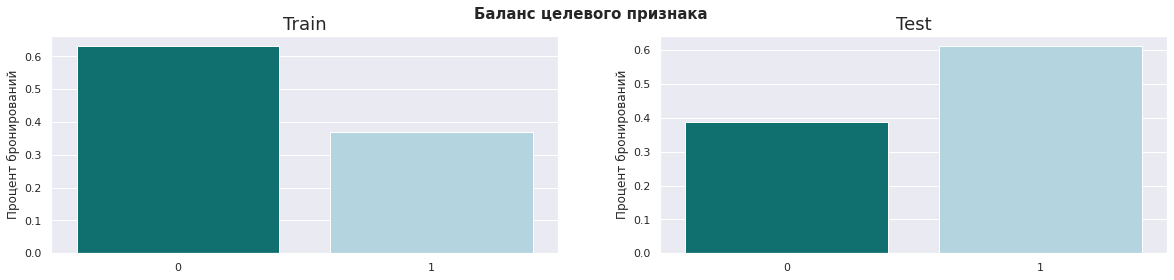

In [30]:
datas = [hotel_train, hotel_test]
fig, ax = plt.subplots(1, 2)

fig.suptitle('Баланс целевого признака', fontweight='bold', fontsize=15)

sns.barplot(data=datas[0], x=hotel_train['is_canceled'].unique(), y=hotel_train['is_canceled'].value_counts(normalize=True), palette=['teal', 'lightblue'],ax=ax[0])
ax[0].set_ylabel('Процент бронирований')
ax[0].set_title('Train', fontsize=18)
    
sns.barplot(data=datas[1], x=hotel_test['is_canceled'].unique(), y=hotel_test['is_canceled'].value_counts(normalize=True), palette=['teal', 'lightblue'],ax=ax[1])
ax[1].set_ylabel('Процент бронирований')
ax[1].set_title('Test', fontsize=18)
plt.show()

<strong>Мы наблюдаем значительный  дисбаланс целевого признака, который нужно в дальнейшем уравнять.</strong>

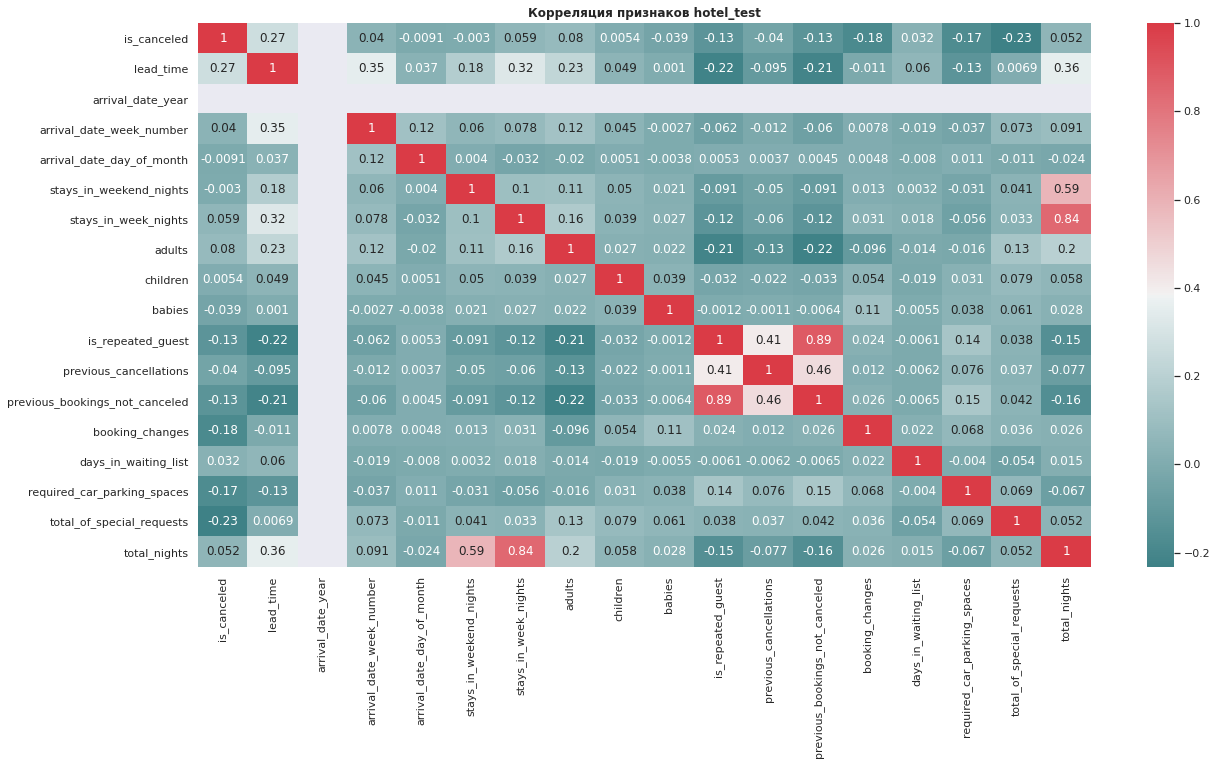

In [31]:
plt.figure(figsize=(20, 10))
plt.title('Корреляция признаков hotel_test', weight = 'bold')
cmap = sns.diverging_palette(200, 10, as_cmap=True)
sns.heatmap(hotel_test.corr(method='spearman'), annot = True, cmap=cmap)
plt.show()

Видим, что наиболеекоррелирующие с отменой признаки это количество взрослых и дистанция от даты брони до заезда. Это нужно взять на вооружение при создании роботов, которые предложат внести предоплату клиенту.

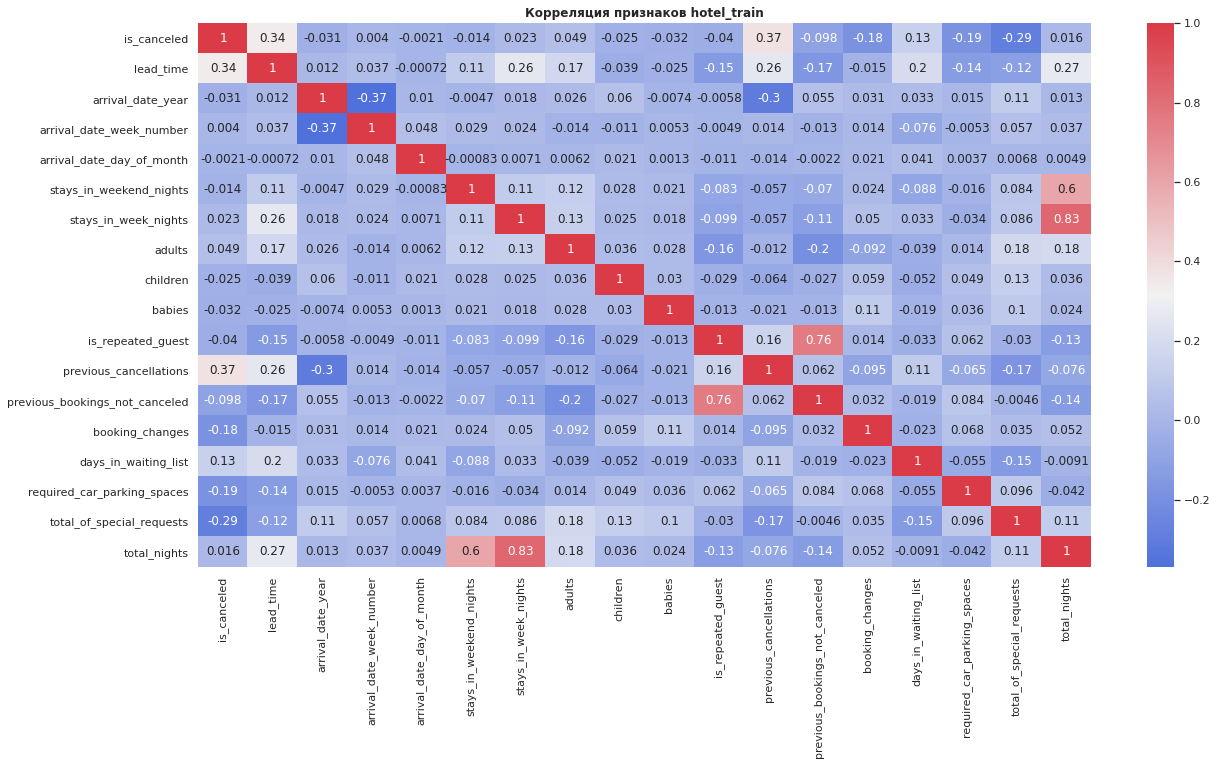

In [32]:
plt.figure(figsize=(20, 10))
plt.title('Корреляция признаков hotel_train', weight = 'bold')
cmap = sns.diverging_palette(260, 10, as_cmap=True)
sns.heatmap(hotel_train.corr(method='spearman'), annot = True, cmap=cmap)
plt.show()

В обучающем сете не изменилось максимальное влияние дистанции между временем регистрации и заездом, но на втором месте видим количество отмененных заказов клиента. Это следует так же учесть

Выводы из изучения корреляций:

 - Отрицательно (прямая зависимость) на ситуацию влияют такие показатели, как количество дней от брони до прибытия, количество взрослых , количество дней ожидания подтверждения, неделя заезда. Графа количество отмененных заказов у клиента в тренировочной выборке имеет прямую зависимость с отменой бронирования, но в тестовой выборке - обратную зависимость. Возможно, за 2017 год у нас имеются неполные данные по этой графе.
 - Положительно влияют инфраструктурные данные такие как парковочные места, корректировка заказа, постоянство пребыаания клиента в данный отель

Взглянем на график объема бронирований в годичном интервале и обратим внимание на сезонность

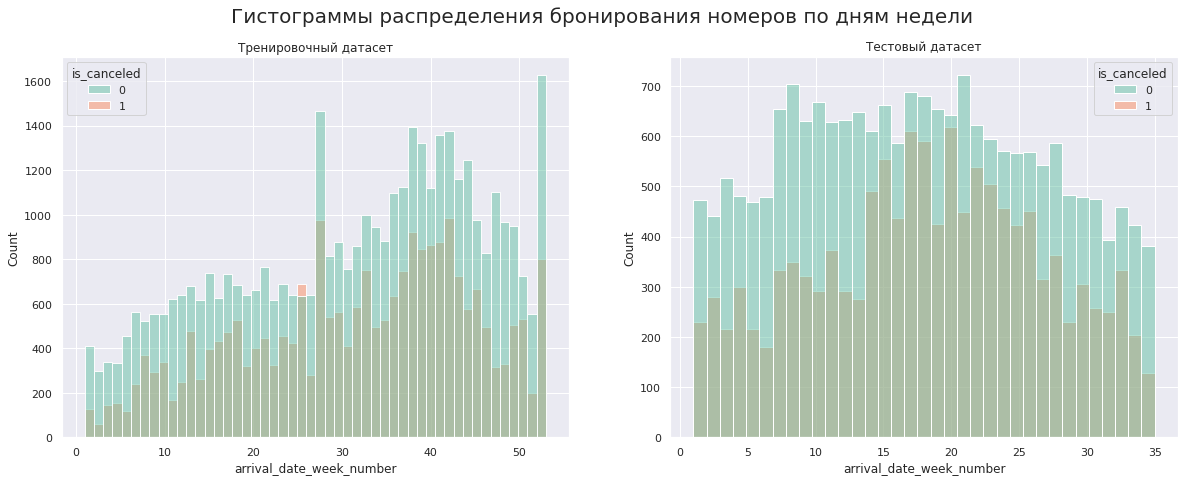

In [33]:
# гистограммы распределения
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Гистограммы распределения бронирования номеров по дням недели', fontsize=20)
axes[0].set_title('Тренировочный датасет')
axes[1].set_title('Тестовый датасет')
sns.histplot(data=hotel_train, x='arrival_date_week_number', bins=50, hue='is_canceled', ax=axes[0])
sns.histplot(data=hotel_test, x='arrival_date_week_number', bins=35, hue='is_canceled', ax=axes[1])
plt.show()

Как видим, пик бронирований приходится на вторую половину года, тогда как в начале и в конце возможны снижения из-за сезонности. Оживление может наблюдаться к Новому Году.

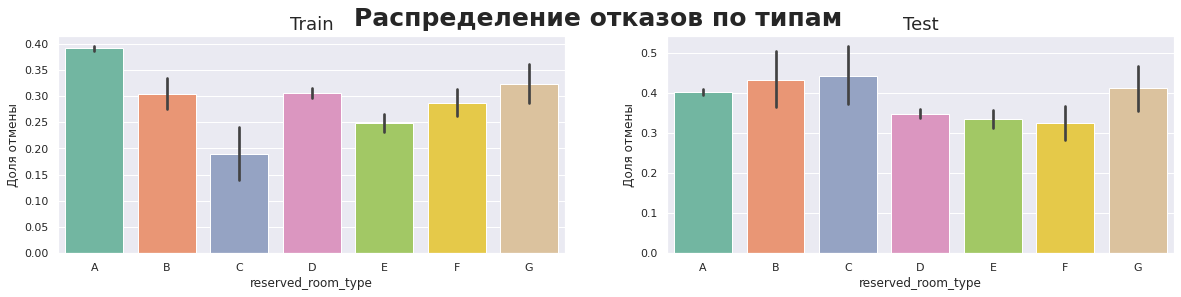

In [34]:
datas = [hotel_train, hotel_test]
fig, ax = plt.subplots(1, 2)

fig.suptitle('Распределение отказов по типам', fontweight='bold', fontsize=25)

sns.barplot(data=datas[0], x='reserved_room_type', y='is_canceled', order = ['A','B','C','D','E','F','G'], ax=ax[0])
ax[0].set_ylabel('Доля отмены')
ax[0].set_title('Train', fontsize=18)
    
sns.barplot(data=datas[1], x='reserved_room_type', y='is_canceled', order = ['A','B','C','D','E','F','G'], ax=ax[1])
ax[1].set_ylabel('Доля отмены')
ax[1].set_title('Test', fontsize=18)
plt.show()


Как видим, в 2017 году (тренировочный датасет) было много отмен по классу А, В, D и G. На тестовой выборке много отмен по B, C, G. Признак А у нас стабильно в топе по отменам. Обратим внимание на required_car_parking_spaces, там замечена высокая корреляция с сохранением бронирования номера.


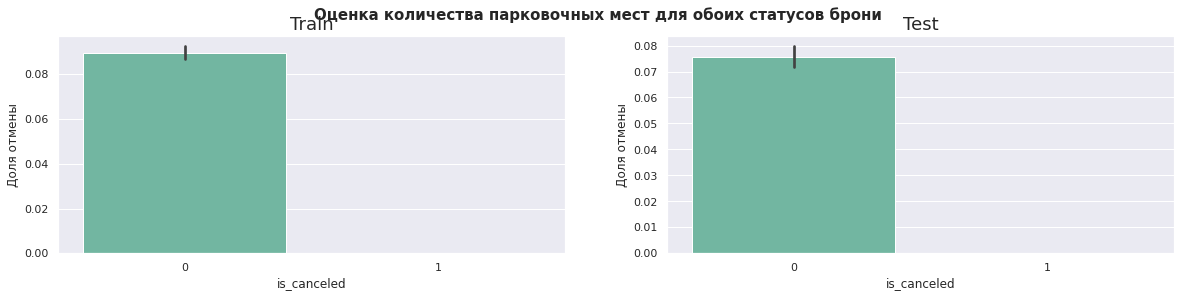

In [35]:
datas = [hotel_train, hotel_test]
fig, ax = plt.subplots(1, 2)

fig.suptitle('Оценка количества парковочных мест для обоих статусов брони', fontweight='bold', fontsize=15)

sns.barplot(data=datas[0], x='is_canceled', y='required_car_parking_spaces',  ax=ax[0])
ax[0].set_ylabel('Доля отмены')
ax[0].set_title('Train', fontsize=18)
    
sns.barplot(data=datas[1], x='is_canceled', y='required_car_parking_spaces', ax=ax[1])
ax[1].set_ylabel('Доля отмены')
ax[1].set_title('Test', fontsize=18)
plt.show()



Отмены практически не происходит,если бронируются паркоместа.

<strong>Давайте соберем основные выводы:</strong>

 - Объем отменяемой брони примерно 37-39 % .
 - Дисбаланс целевого признака следует уровнять, однако он не кретичен.
 - Выявленны отрицательно влияющие показатели на отмену. Это дистанция от брони до прибытия, количество взрослых постояльцев, время од+жидание подтверждения, неделя заезда. Втренировочной выборке прямая зависимость между отменой и количеством предыдущих отмен, а в тестовой наоборот.
 - Наличие заполненных граф со спецотметками оказывает положительное влияние, парковка, изменение в заказе, постоянство посещения клиентом отеля.
 - Средина года наиболее активная фаза посещений которая обусловленна, скорее всего сезонностью. Новогодний период так же является активным.
 - Значения в столбце lead_time имеет выбросы и логнормальное распределение. Средний показатель 97,5. Очевидная корреляция, которую следует взять во внимание.
 - Бронирование автоместа, верный индикатор намерения, который с большой вероятностью исключает отмену брони.
 - Отмена номеров по срезу классов не сильно разница в тернировочной и тестовой выборке, однако Класс "С" в тренировочной, наименее отменяем, тогда как в тестовой наоборот имеет максимальное значение.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Базовая бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца это неизменный фактор

В отеле есть несколько типов номеров, каждый из которых имеет свою стоимость. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

<strong>Стоимость номеров отеля:</strong>

 - категория A: за ночь — 1 000, разовое обслуживание — 400;
 - категория B: за ночь — 800, разовое обслуживание — 350;
 - категория C: за ночь — 600, разовое обслуживание — 350;
 - категория D: за ночь — 550, разовое обслуживание — 150;
 - категория E: за ночь — 500, разовое обслуживание — 150;
 - категория F: за ночь — 450, разовое обслуживание — 150;
 - категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%. Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Создадим список для удобства:

In [36]:
month_up = pd.DataFrame({'arrival_date_month': ['January', 'February', 'March', 'April', 'May', 'June', 
                                    'July', 'August', 'September','October', 'November', 'December'], 
                            'k': [1.0, 1.0, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4, 1.2, 1.2, 1.2, 1.0],
                            'n_month': [1,2,3,4,5,6,7,8,9,10,11,12]})

In [37]:
month_up

,arrival_date_month,k,n_month
0,January,1.0,1
1,February,1.0,2
2,March,1.2,3
3,April,1.2,4
4,May,1.2,5
5,June,1.4,6
6,July,1.4,7
7,August,1.4,8
8,September,1.2,9
9,October,1.2,10


In [38]:
room_lev_pay = pd.DataFrame({'reserved_room_type': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
                           'price_per_night': [1000, 800, 600, 550, 500, 400, 350, 300],
                           'room_service': [400, 250, 250, 150, 150, 150, 150, 100]})

In [39]:
room_lev_pay

,reserved_room_type,price_per_night,room_service
0,A,1000,400
1,B,800,250
2,C,600,250
3,D,550,150
4,E,500,150
5,F,400,150
6,G,350,150
7,H,300,100


Добавим столбцы к датасету

In [40]:
hotel_train = hotel_train.merge(month_up,how='left',on='arrival_date_month')

In [41]:
hotel_train = hotel_train.merge(room_lev_pay,how='left',on='reserved_room_type')

In [42]:
hotel_test = hotel_test.merge(month_up,how='left',on='arrival_date_month')

In [43]:
hotel_test = hotel_test.merge(room_lev_pay,how='left',on='reserved_room_type')

In [44]:
hotel_train.head(5)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,k,n_month,price_per_night,room_service
0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1,1.4,7,1000,400
1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2,1.4,7,1000,400
2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2,1.4,7,600,250
3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2,1.4,7,600,250
4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3,1.4,7,1000,400


<strong>Преобразуем категориальные признаки в количественные методом прямого кодирования</strong>

In [45]:
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
feature_arr = ohe.fit_transform(hotel_train[hotel_train.select_dtypes(include=['object']).columns])
feature_labels = ohe.get_feature_names(hotel_train.select_dtypes(include = ['object']).columns)
ohe_train = pd.DataFrame(feature_arr, columns=feature_labels)

In [46]:
features_arr = ohe.transform(hotel_test[hotel_test.select_dtypes(include=['object']).columns])
ohe_test = pd.DataFrame(features_arr,columns=feature_labels)

In [47]:
print('Кол-во строк и столбцов в ohe обучающей выборке:', ohe_train.shape)
print('Кол-во строк и столбцов в ohe тестовой выборке:', ohe_test.shape)

Кол-во строк и столбцов в ohe обучающей выборке: (65214, 186)
Кол-во строк и столбцов в ohe тестовой выборке: (32405, 186)


Кодируем данные с основным массивом и дропаем не кодированные категориальные столбцы:

Исключим категориальные столбцы из новых массивов и произведем соединение с кодированным по индексам, проверив количество строк и столбцов до этого, для уверенности, что все сделанно правильно:

In [48]:
fd = hotel_train[hotel_train.select_dtypes(include=['int','float']).columns]

In [49]:
wd = hotel_test[hotel_test.select_dtypes(include=['int','float']).columns]

In [50]:
print('Кол-во строк и столбцов fd выборке:', fd.shape)
print('Кол-во строк и столбцов wd выборке:', wd.shape)

Кол-во строк и столбцов fd выборке: (65214, 22)
Кол-во строк и столбцов wd выборке: (32405, 22)


In [51]:
ohe_train = pd.merge(fd,ohe_train, left_index=True, right_index=True)

In [52]:
ohe_test = pd.merge(wd,ohe_test, left_index=True, right_index=True)

In [53]:
print('Кол-во строк и столбцов в ohe обучающей выборке:', ohe_train.shape)
print('Кол-во строк и столбцов в ohe тестовой выборке:', ohe_test.shape)

Кол-во строк и столбцов в ohe обучающей выборке: (65214, 208)
Кол-во строк и столбцов в ohe тестовой выборке: (32405, 208)


In [54]:
ohe_train.head(5)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,k,n_month,price_per_night,room_service,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,country_ABW,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ATA,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FRA,country_GAB,country_GBR,country_GEO,country_GGY,country_GIB,country_GLP,country_GNB,country_GRC,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KNA,country_KOR,country_KWT,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MUS,country_MWI,country_MYS,country_NAM,country_NGA,country_NIC,country_NLD,country_NOR,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SEN,country_SGP,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,7.0,2015,27,1,0,1,1.0,0.0,0.0,0,0,0,0,0,0,0,1,1.4,7,1000,400,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,14.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,1,2,1.4,7,1000,400,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [55]:
ohe_test.head(5)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,k,n_month,price_per_night,room_service,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,country_ABW,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ATA,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FRA,country_GAB,country_GBR,country_GEO,country_GGY,country_GIB,country_GLP,country_GNB,country_GRC,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KNA,country_KOR,country_KWT,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MUS,country_MWI,country_MYS,country_NAM,country_NGA,country_NIC,country_NLD,country_NOR,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SEN,country_SGP,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1,74.0,2017,1,1,1,0,2.0,0.0,0.0,0,0,0,0,0,0,0,1,1.0,1,1000,400,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,62.0,2017,1,1,2,2,2.0,0.0,0.0,0,0,0,0,0,0,1,4,1.0,1,1000,400,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

Разделим на обучающие признаки и целевые:

In [56]:
features_train = ohe_train.drop(['is_canceled'], axis=1)
target_train = ohe_train['is_canceled']

In [57]:
features_test = ohe_test.drop(['is_canceled'], axis=1)
target_test = ohe_test['is_canceled']

Масштабируем:

In [58]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

Прибыль отеля - это разница между стоимостью номера за все ночи и затраты на разовое обслуживание: как при подготовке номера, так и при проживании постояльца:

In [59]:
hotel_test.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,k,n_month,price_per_night,room_service
0,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1.0,1,1000,400
1,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.0,1,1000,400
2,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.0,1,1000,400
3,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.0,1,1000,400
4,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.0,1,1000,400


Исключим из тестовой выборки все признаки, которые не относятся к финансовым.

In [60]:
profit_table = hotel_test.drop(columns = ['lead_time', 'arrival_date_year',
                                          'arrival_date_week_number', 'arrival_date_day_of_month',
                                          'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
                                          'babies', 'meal', 'country', 'distribution_channel',
                                          'is_repeated_guest', 'previous_cancellations',
                                          'previous_bookings_not_canceled', 'booking_changes',
                                          'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces',
                                          'total_of_special_requests'],axis=1)

In [61]:
profit_table.head()

,is_canceled,arrival_date_month,reserved_room_type,total_nights,k,n_month,price_per_night,room_service
0,1,January,A,1,1.0,1,1000,400
1,1,January,A,4,1.0,1,1000,400
2,1,January,A,4,1.0,1,1000,400
3,1,January,A,4,1.0,1,1000,400
4,1,January,A,7,1.0,1,1000,400


Расчитаем прибыль функцией

In [62]:
def profit(row):
    if row['is_canceled']==0:
        income = row['price_per_night']*row['total_nights']*row['k']
        expans = row['room_service']*round(row['total_nights']/2)
    else:
        income=0
        expans = row['price_per_night']*row['k']+row['room_service']
    profit = income - expans
    return profit

In [63]:
profit_table['total_profit'] = profit_table.apply(profit,axis=1)

In [64]:
profit_table.head()

,is_canceled,arrival_date_month,reserved_room_type,total_nights,k,n_month,price_per_night,room_service,total_profit
0,1,January,A,1,1.0,1,1000,400,-1400.0
1,1,January,A,4,1.0,1,1000,400,-1400.0
2,1,January,A,4,1.0,1,1000,400,-1400.0
3,1,January,A,4,1.0,1,1000,400,-1400.0
4,1,January,A,7,1.0,1,1000,400,-1400.0


In [65]:
print('Выручка без внедрения депозита составляет:',profit_table['total_profit'].sum())

Выручка без внедрения депозита составляет: 50908170


ВЫВОД

 - дополнили датасет удобными данными для расчетов
 - применили one code encoder для кодировки данных типа object, объеденив получившиеся данные с исходным массивом, где исключили категориальные признаки. В результате получили новые дата сеты: ohe_train и ohe_test
 - разделили данные на выборки и произвели масштабирование
 - произвели расчет затрат на номер за все дни и разовое обслуживание: отдельно с проживанием и без проживания
 - выручка, которая получилась без внедрения депозита, составила: 50_908_170

### Шаг 4. Разработка модели ML

<strong>Выбор лучшей модели</strong>

Обучим модели и  выберем лучшую из них на основании метрики - auc_roc.

<strong>Logistic Regression</strong>

In [66]:
lg_params = {'penalty':['l1','l2'],'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],'solver':['saga']}

lg_gs = GridSearchCV(LogisticRegression(solver='liblinear', random_state=RANDOM_STATE),
                 lg_params,
                 cv = 5,
                 scoring = 'roc_auc')
lg = lg_gs.fit(features_train, target_train)

In [67]:
print('Оптимальные параметры: ',lg.best_params_)

Оптимальные параметры:  {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}


In [68]:
print(f'Лучший roc_auc на обучающей выборке: {lg.score(features_train, target_train)}')

Лучший roc_auc на обучающей выборке: 0.8489939861892739


In [69]:
print('Лучшие параметры: ',lg.best_score_)

Лучшие параметры:  0.7102330205107276


In [ ]:
scores_lg = cross_val_score(lg, features_test, target_test, cv=5, scoring = 'roc_auc')

In [ ]:
scores_lg_tr = cross_val_score(lg, features_train, target_train, cv=5, scoring = 'roc_auc' )

In [ ]:
final_score_lg = scores_lg.mean()

In [ ]:
final_score_lg_tr = scores_lg_tr.mean()

Обучим новую модель Дерево решений

<strong>DecisionTree</strong>

In [ ]:
dt_params = {
    'max_depth': [2, 4, 8, 16],
    'min_samples_split': range(5,55,10), 
    'min_samples_leaf': [2, 3, 5, 10],
    'class_weight':['balanced']
}

dt_gs_auc = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE),
                         dt_params, n_jobs=-1,cv = 5,scoring = 'roc_auc')
dt_auc = dt_gs_auc.fit(features_train, target_train)

In [ ]:
print('Оптимальные параметры: ',dt_auc.best_params_) 

In [ ]:
print(f'Лучший roc_auc на обучающей выборке: {dt_auc.score(features_train, target_train)}')

In [ ]:
print('Лучшие параметры: ',dt_auc.best_score_)

In [ ]:
scores_dt_auc = cross_val_score(dt_auc, features_test, target_test, cv=5, scoring = 'roc_auc')

In [ ]:
scores_dt_auc_tr = cross_val_score(dt_auc, features_train, target_train, cv=5, scoring = 'roc_auc' )

In [ ]:
final_dt_auc = scores_dt_auc.mean()

In [ ]:
final_dt_auc_tr = final_dt_auc_tr.mean()

Дерево решений дает нам похожий результат по обучающей выборке и чуть ниже по тестовой 0.78 против 0.81 в модели Логистической регрессии.

Были выбраны лучшие результаты функцией best_params и следовательно исключать возможность использовать еще одно решение не стоит.

Обучим модель с помощью Random Forest Classifier

<strong>Random Forest</strong>

In [ ]:
rf_params = {
    'criterion':['gini','entropy'],
    'n_estimators': [2, 5, 10, 30, 50],
    'max_depth': [2, 4, 8, 16],
    'min_samples_leaf': [2,3,5,10],
    'class_weight':['balanced']
}

rf_gs = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE),
                     rf_params, cv = 10, scoring = 'roc_auc',
                     verbose=2)
rf_auc = rf_gs.fit(features_train, target_train)

In [ ]:
print('Оптимальные параметры: ', rf_auc.best_params_) 

In [ ]:
print(f'Лучший roc_auc на обучающей выборке: {rf_auc.score(features_train, target_train)}')

In [ ]:
print('Лучшие параметры: ',rf_auc.best_score_)

In [ ]:
scores_rf_auc = cross_val_score(rf_auc, features_test, target_test, cv=5)

In [ ]:
scores_rf_auc_tr = cross_val_score(lg, features_train, target_train, cv=5, scoring = 'roc_auc' )

In [ ]:
final_rf_auc = scores_rf_auc.mean()

In [ ]:
final_rf_auc_tr = scores_rf_auc_tr.mean()

Сделаем сводную таблицу лучших  параметров модели

In [ ]:
predictive_model_scores = pd.DataFrame(data=[('Logistic Regression',lg.score(features_train, target_train), lg.score(features_test, target_test)), 
                                             ('Decision Tree',dt_auc.score(features_train, target_train),dt_auc.score(features_test, target_test)), 
                                             ('Random Forest',rf_auc.score(features_train, target_train), rf_auc.score(features_test, target_test))], 
                                       columns=['model', 'training_roc_auc', 'testing_roc_auc'])
predictive_model_scores

Дерево решений у нас показала наилучший результат, исходя из чего дальнейшие расчеты будут проводиться применительно к модели Случайный лес.

Сохраним результаты предсказаний в переменных

In [ ]:
predicted_test_rf = rf_auc.predict(features_test)

Создадим новые колонки в датасете с доходом

In [ ]:
profit_table['ml_pred_rf'] = predicted_test_rf

Сделаем матрицу ошибок для лучшей модели

In [ ]:
cm_rf = confusion_matrix(target_test, predicted_test_rf)

In [ ]:
cm_df_rf = pd.DataFrame(cm_rf, index=['Actually Not Canceled', 'Actually Canceled'],
                 columns=['Predicted Not Canceled', 'Predicted Canceled'])

Смотрим результаты

In [ ]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10,4))
    
sns.heatmap(cm_rf, annot=True, fmt='g', cmap="Greens",xticklabels=cm_df_rf.columns, yticklabels=cm_df_rf.index, annot_kws={"size": 20})
plt.title("Матрица ошибок", size=20)
plt.xlabel('Класс предсказаний')
plt.ylabel('Реальный класс');

In [ ]:
TP = cm_rf[0][0]
TN = cm_rf[1][1]
FP = cm_rf[0][1]
FN = cm_rf[1][0]
total = cm_rf[0][0]+cm_rf[1][1]+cm_rf[0][1]+cm_rf[1][0]

print('All Prediction :',total)
print(f'True Identification: {np.round((TP+TN)/total*100)}%')
print(f'Доля правильных предсказаний по отмене среди ошибочно не отмененных:       {np.round(TP/(TP+FN)*100)}%')
print(f'Доля правильно предсказанных не отмен среди ложно отмененных:              {np.round(TN/(TN+FP)*100)}%')
print(f'Доля правильных предсказаний по отмене среди ошибочно отмененных:          {np.round(TP/(TP+FP)*100)}%')
print(f'Доля правильно предсказанных не отмен среди ложно неотмененных:            {np.round(TN/(TN+FN)*100)}%')

 - Модель достигла результата в 80% правильных предсказаний по отмене брони.
 - 59% правильных предсказаний по не отмене в ложноотмененных итерациях
 - итого получилось 15810 правильно предсказанных отмен

Произведем расчет прибыльности модели

Оценим, насколько прибыльна модель для внедрения

In [ ]:
def profit_pred(row, col):
    if row['is_canceled']==0:                                           #расчет, если небыло отмены
        income = row['price_per_night']*row['total_nights']*row['k']
        expans = row['room_service']*round(row['total_nights']/2)
    elif (row[col]==0) and (row['is_canceled']==1):                     # также, при неправильном предсказании отмены
        income = 0
        expans = row['price_per_night']*row['k']+row['room_service']
    elif (row[col]==1) and (row['is_canceled']==1):                     # плюс при правильном предсказании
        income= (row['price_per_night']*row['k']+row['room_service'])*0.8
        expans = row['price_per_night']*row['k']+row['room_service']
    profit_pred = income - expans                                       #получим профит за вычетом расходов
    return profit_pred

In [ ]:
profit_table['profit_pred_rf'] = profit_table.apply(profit_pred, col='ml_pred_rf', axis=1)

In [ ]:
print('Выручка после обучения модели Random Forest:',profit_table['profit_pred_rf'].sum())

In [ ]:
print('Модель Random Forest принесёт компании выручку:',profit_table['profit_pred_rf'].sum() - profit_table['total_profit'].sum())

<strong>Вывод</strong>

Трех моделей, достаточно для понимания возможных результатов обучения. Лучшим оказалась модель Случайный лес:
 - Случайный Лес(roc_auc=0.865900)
 - Логистическая Регрессия(roc_auc=0.848994)
 - Дерево Решений (roc_auc=0.849862)

Реализовали матрицу ошибок, которая подтвердила правильность выбранной модели.

Модель Случайны лес принесет компании прибыль 56_434_730.0

Прибыль после внедрения составит 5_526_560.0

### Шаг 5. Опишем портрет «ненадёжного» клиента

Для определения статуса "Надежный клиент", достаточно взглянуть на тепловую карту, с противоположной стороны от основного признака.

In [ ]:
sns.heatmap(data.corr()[['is_canceled']].sort_values('is_canceled', ascending=False),
                annot = True, annot_kws = {"size":12}, cmap='Blues')
plt.show()

 - С уверенностью можно сказать, что уверенности добавляют факторы вовлеченности клиента в процесс оформления. Другими словами наличие отметок в специальных графах, дополняющих базовые метрики заказа.
 - Если клиент рассматривает парковочное место, то это верный признак уверенности в приезде.
 - Когда происходит корректировка параметров, то намерение устойчивое, добавляющее балл в пользу приезда.
 - Человек, которого можно считать постояльцем, так же является надежным в отношении брони.

<strong>Довершая портрет надежного клиент, стоит отметить взаимосвязь вовлеченности и результата!!! В качестве рекомендации можно отметить необходимость расширения концептов отеля, для перевешивания решения в пользу приезда.</strong>

### Шаг 6. Вывод

Провели исследовательский анализ по прогнозированию оттока клиентов и получили ряд метрик и взаимосвязей.
 - Выявили наиболее коррелирующие признаки с основным. Временной фактор оказывает ключевое значение в отмене - чем дальше к дате приезда, тем выше вероятность отмены.
 - Определили наиболее популярные временные интервалы для посещений - это лето и частично новогодний период
 - Нашли взаимосвязи между типами номеров и отказами. Это тема для отдельного исследования.
 - Расширили датасет, добавив новые признаки, участвующие в дальнейших расчетах. Бизнесметрики всегда кстати.
 - Провели обучение трех моделей и выбрали наиболее продуктивную. Случайный лес принес 5 млн. дополнительной прибыли
 - Расчитали чистую прибыль после всех вычетов и затратных мероприятий.
 - Определили признаки надежного клиента. Хорошая тема для улучшения бизнеса и повышения качества обслуживания.